<a href="https://colab.research.google.com/github/tronglinux123/EHR_Transfer_Learning/blob/main/Evaluation_SMOTE_and_XGBClassifier_XGBRegressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip freeze | grep scikit

scikit-image==0.25.2
scikit-learn==1.6.1


In [ ]:
from google.cloud import bigquery
from google.colab import auth, drive
import os
# Mount to Google Drive if data on Drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/doan_demo')
os.getcwd()

Mounted at /content/drive


'/content/drive/MyDrive/doan_demo'

In [ ]:
from typing import Callable
from xgboost import XGBClassifier, XGBRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
import warnings
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
import gc
warnings.filterwarnings('ignore')



In [ ]:
df = pd.read_csv('x_ray_and_features_data.csv')

diseases = ['pneumonia', 'tuberculosis', 'bronchitis', 'arthritis', 'fracture', 'lung_cancer', 'scoliosis', 'lung_infection']
mimic_feats = ['diabete', 'age', 'hiv', 'oxygen', 'heart_rate', 'temperature', 'hemoglobin', 'rbc', 'wbc', 'smoke', 'cough']
img_feats = [str(x) for x in range(18)]
models = [XGBClassifier]
# Keep the necessary data
data = df[img_feats+mimic_feats]

In [ ]:
data

,0,1,2,3,4,5,6,7,8,9,...,age,hiv,oxygen,heart_rate,temperature,hemoglobin,rbc,wbc,smoke,cough
0,-1.920675,-3.472368,3.423497e-39,-4.019975,-2.682965,3.095561e-39,2.350940e-40,-2.235377,-4.163281,-4.595403e-39,...,50,0,NaN,NaN,NaN,11.9,4.40,5.5,0,0
1,0.088068,-1.032863,2.666148e-39,-3.083943,-0.214080,1.675793e-39,-5.305300e-40,0.470033,-1.843389,-2.014102e-39,...,76,0,NaN,NaN,NaN,12.1,3.86,9.3,0,0
2,-0.521883,-0.844022,1.648815e-39,-2.451156,0.017114,-9.188970e-40,2.053338e-39,-0.687770,-1.140900,1.666720e-39,...,76,0,NaN,NaN,NaN,12.1,3.86,9.3,0,0
3,0.401914,-1.997322,-4.848840e-40,-3.875956,-0.883333,-1.451999e-39,-8.226740e-40,-0.259665,-1.303978,8.319800e-41,...,76,0,NaN,NaN,NaN,12.1,3.86,9.3,0,0
4,-1.056595,-4.040716,1.544811e-39,-4.820945,-2.704534,-7.036560e-40,-1.042745e-39,-2.362798,-2.435506,-2.722800e-39,...,56,1,NaN,NaN,NaN,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29078,-3.728611,-4.977847,3.031653e-39,-5.108873,-5.318205,1.355334e-39,-1.813954e-39,-3.791145,-5.012530,-1.308602e-38,...,32,1,NaN,NaN,NaN,6.6,2.45,2.4,0,0
29079,-2.983252,-4.527564,3.047530e-40,-5.296632,-4.274313,1.801090e-39,3.243934e-39,-3.313225,-4.193819,-8.045227e-39,...,32,1,NaN,NaN,NaN,6.6,2.45,2.4,0,0
29080,0.508512,-1.068828,5.612754e-39,-3.753665,-0.220833,2.278004e-39,1.523423e-39,0.121205,-3.017588,2.945640e-40,...,32,1,NaN,NaN,NaN,6.6,2.45,2.4,0,0
29081,-0.743946,-2.159284,-4.178940e-40,-4.024840,-0.524709,-2.100615e-39,1.569922e-39,-0.918786,-3.664216,1.304308e-39,...,32,1,NaN,NaN,NaN,6.6,2.45,2.4,0,0


In [ ]:
def classify_and_compare(clf: Callable, d, l,
                         test:float = 0.35,
                         verbose:int = 0,
                         print_res:bool = False,
                         df = None,
                         engineering:str = 'None',
                         disease:str = 'None',
                         seed: int = None):
  r'''
  Compare data with and without additional MIMIC-IV Features

  Params
  ---
  - `clf`: The classifier initialization function (sklearn style)
  - `d`: dataset that contains both MIMIC-IV and image data features
  - `l`: label data
  - `test`: test split ratio
  - `verbose`: If you want to print out the progress in the classfier while fitting
  - `print_res`: If result is to be printed or exported to a dataframe column
  - `df`: the dataframe to append results to if not printing
  - `engineering`: Specify if any data engineering is done
  - `disease`: Name of the disease being classified
  '''
  # Split to train and test
  xtr, xte, ytr, yte = train_test_split(d, l, test_size=test, random_state=seed)

  # c1: With all features
  b = clf().fit(xtr,ytr)
  p = b.predict(xte)
  c1 = classification_report(yte, p, output_dict = not print_res)

  # c2: Image features only
  b = clf().fit(xtr[img_feats],ytr)
  p = b.predict(xte[img_feats])
  c2 = classification_report(yte, p, output_dict = not print_res)

  # c3: Original structure: a linear layer with sigmoid activation on image features
  b = LogisticRegression().fit(xtr[img_feats],ytr)
  p = b.predict(xte[img_feats])
  c3 = classification_report(yte, p, output_dict = not print_res)

  # Either print result or append to dataframe
  if print_res:
    print(c1 + '\n' + c2 + '\n' + c3)
  else:
    col = pd.Series({'Model': clf.__name__,
                     'Engineering': engineering,
                     'Disease': disease,
                     # Accuracy
                     'acc_e': c1['accuracy'],
                     'acc_o': c2['accuracy'],
                     'acc_d': c1['accuracy'] - c2['accuracy'],
                     'acc_i': c2['accuracy'] - c3['accuracy'],
                     'acc_x': c1['accuracy'] - c3['accuracy'],
                     # Precision for negative
                     'p0_e': c1['0']['precision'],
                     'p0_o': c2['0']['precision'],
                     'p0_d': c1['0']['precision'] - c2['0']['precision'],
                     # Precision for positive
                     'p1_e': c1['1']['precision'],
                     'p1_o': c2['1']['precision'],
                     'p1_d': c1['1']['precision'] - c2['1']['precision'],
                     'p1_i': c2['1']['precision'] - c3['1']['precision'],
                     'p1_x': c1['1']['precision'] - c3['1']['precision'],
                     # Recall for negative
                     'r0_e': c1['0']['recall'],
                     'r0_o': c2['0']['recall'],
                     'r0_d': c1['0']['recall'] - c2['0']['recall'],
                     # Recall for positive
                     'r1_e': c1['1']['recall'],
                     'r1_o': c2['1']['recall'],
                     'r1_d': c1['1']['recall'] - c2['1']['recall'],
                     # F1-score negative
                     'f1_0_e': c1['0']['f1-score'],
                     'f1_0_o': c2['0']['f1-score'],
                     # F1-score positive
                     'f1_1_e': c1['1']['f1-score'],
                     'f1_1_o': c2['1']['f1-score'],
                     })
    df[len(df.columns)] = col

In [ ]:
def classify_and_compare_SMOTE(clf: Callable, d, l,
                         test:float = 0.35,
                         verbose:int = 0,
                         print_res:bool = False,
                         df = None,
                         engineering:str = 'None',
                         disease:str = 'None',
                         seed: int = None):
  r'''
  Compare data with and without additional MIMIC-IV Features

  Params
  ---
  - `clf`: The classifier initialization function (sklearn style)
  - `d`: dataset that contains both MIMIC-IV and image data features
  - `l`: label data
  - `test`: test split ratio
  - `verbose`: If you want to print out the progress in the classfier while fitting
  - `print_res`: If result is to be printed or exported to a dataframe column
  - `df`: the dataframe to append results to if not printing
  - `engineering`: Specify if any data engineering is done
  - `disease`: Name of the disease being classified
  '''
  # Split to train and test
  xtr, xte, ytr, yte = train_test_split(d, l, test_size=test, random_state=seed)
  xtr = xtr.reset_index(drop=True)
  ytr = ytr.reset_index(drop=True)

  full_feats = img_feats + mimic_feats
  cat_feats = ['diabete', 'hiv', 'smoke', 'cough']
  sm = SMOTE(sampling_strategy=1, random_state=42)
  xtr_img_sm, ytr_sm = sm.fit_resample(xtr[img_feats], ytr)
  n_original = len(xtr)
  n_total = len(xtr_img_sm)
  n_synthetic = n_total - n_original

  xtr_final = pd.DataFrame()
  xtr_final[img_feats] = xtr_img_sm
  xtr_final.loc[:n_original-1, mimic_feats] = xtr[mimic_feats].values
  xtr_final.loc[n_original:, mimic_feats] = np.nan
  X_train_final = xtr_final
  y_train_final = ytr_sm
  X_train_img = xtr[img_feats]
  X_train_labels = xtr[cat_feats]
  X_synth_img = X_train_final.loc[n_original:, img_feats]
  models_cat = {}
  for col in cat_feats:
      mask = X_train_labels[col]
      n_pos = mask.sum()
      n_neg = len(mask) - n_pos
      model = XGBClassifier(
          n_estimators=200,
          max_depth=4,
          learning_rate=0.05,
          subsample=0.8,
          colsample_bytree=0.8,
          random_state=42,
          scale_pos_weight = n_neg / n_pos
      )

      model.fit(X_train_img, X_train_labels[col])
      models_cat[col] = model
  preds = {}
  for col in cat_feats:
      preds[col] = models_cat[col].predict(X_synth_img)
  for col in cat_feats:
      X_train_final.loc[n_original:, col] = preds[col]
  mimic_numeric = ['oxygen', 'heart_rate', 'temperature',
                   'hemoglobin', 'rbc', 'wbc']
  models_mask = {}
  models_value = {}

  for num in mimic_numeric:
    mask = xtr[num].notna().astype(int)
    n_pos = mask.sum()
    n_neg = len(mask) - n_pos
    X_train_num_input = pd.concat([X_train_img, X_train_labels], axis=1)

    # model mask (classifier)
    mask_model = XGBClassifier(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        scale_pos_weight = n_neg / n_pos
    )

    mask_model.fit(X_train_num_input, mask)
    models_mask[num] = mask_model

    # model value (regression)
    value_model = XGBRegressor(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

    value_model.fit(X_train_num_input[mask == 1], xtr.loc[mask == 1, num])
    models_value[num] = value_model


  X_synth_input = pd.concat([X_synth_img, X_train_final.loc[n_original:, cat_feats]], axis=1)

  for num in mimic_numeric:
      mask_pred = models_mask[num].predict(X_synth_input)
      idx_has_value = (mask_pred == 1)

      if idx_has_value.sum() > 0:
          values = models_value[num].predict(X_synth_input[idx_has_value])
          X_train_final.loc[n_original:].loc[idx_has_value, num] = values


  b = clf().fit(X_train_final,y_train_final)
  p = b.predict(xte)
  c1 = classification_report(yte, p, output_dict = not print_res)

  # c2: Image features only
  b = clf().fit(X_train_final[img_feats],y_train_final)
  p = b.predict(xte[img_feats])
  c2 = classification_report(yte, p, output_dict = not print_res)

  # c3: Original structure: a linear layer with sigmoid activation on image features
  b = LogisticRegression().fit(X_train_final[img_feats],y_train_final)
  p = b.predict(xte[img_feats])
  c3 = classification_report(yte, p, output_dict = not print_res)

  # Either print result or append to dataframe
  if print_res:
    print(c1 + '\n' + c2 + '\n' + c3)
  else:
    col = pd.Series({'Model': clf.__name__,
                     'Engineering': engineering,
                     'Disease': disease,
                     # Accuracy
                     'acc_e': c1['accuracy'],
                     'acc_o': c2['accuracy'],
                     'acc_d': c1['accuracy'] - c2['accuracy'],
                     'acc_i': c2['accuracy'] - c3['accuracy'],
                     'acc_x': c1['accuracy'] - c3['accuracy'],
                     # Precision for negative
                     'p0_e': c1['0']['precision'],
                     'p0_o': c2['0']['precision'],
                     'p0_d': c1['0']['precision'] - c2['0']['precision'],
                     # Precision for positive
                     'p1_e': c1['1']['precision'],
                     'p1_o': c2['1']['precision'],
                     'p1_d': c1['1']['precision'] - c2['1']['precision'],
                     'p1_i': c2['1']['precision'] - c3['1']['precision'],
                     'p1_x': c1['1']['precision'] - c3['1']['precision'],
                     # Recall for negative
                     'r0_e': c1['0']['recall'],
                     'r0_o': c2['0']['recall'],
                     'r0_d': c1['0']['recall'] - c2['0']['recall'],
                     # Recall for positive
                     'r1_e': c1['1']['recall'],
                     'r1_o': c2['1']['recall'],
                     'r1_d': c1['1']['recall'] - c2['1']['recall'],
                     # F1-score negative
                     'f1_0_e': c1['0']['f1-score'],
                     'f1_0_o': c2['0']['f1-score'],
                     # F1-score positive
                     'f1_1_e': c1['1']['f1-score'],
                     'f1_1_o': c2['1']['f1-score'],

                     })
    df[len(df.columns)] = col

In [ ]:
base_seed = 42
# Number of times run per model
n_iter = 5
# Desired test size
test_size = 0.35
res_default = pd.DataFrame()

# For each group of disease and model, perform n comparison runs
for d in tqdm.tqdm(diseases):
  l = df[d]
  for m in models:
    for i in range(n_iter):
      classify_and_compare(m, data, l, test_size, df=res_default, engineering='None', disease=d, seed=base_seed + i)

res_default.T

100%|██████████| 8/8 [01:10<00:00,  8.81s/it]


,Model,Engineering,Disease,acc_e,acc_o,acc_d,acc_i,acc_x,p0_e,p0_o,...,r0_e,r0_o,r0_d,r1_e,r1_o,r1_d,f1_0_e,f1_0_o,f1_1_e,f1_1_o
0,XGBClassifier,None,pneumonia,0.782711,0.701572,0.081139,-0.024067,0.057073,0.796267,0.731227,...,0.941376,0.930815,0.010561,0.363278,0.095562,0.267717,0.862762,0.819037,0.478548,0.149496
1,XGBClassifier,None,pneumonia,0.7889,0.708153,0.080747,-0.023183,0.057564,0.802261,0.736542,...,0.943982,0.935519,0.008463,0.366959,0.089547,0.277412,0.86737,0.824191,0.483041,0.141578
2,XGBClassifier,None,pneumonia,0.782613,0.702259,0.080354,-0.021218,0.059136,0.793017,0.729632,...,0.946647,0.934971,0.011675,0.353234,0.093106,0.260128,0.863048,0.819637,0.473221,0.147398
3,XGBClassifier,None,pneumonia,0.78664,0.702554,0.084086,-0.025442,0.058644,0.801565,0.732845,...,0.939557,0.930788,0.00877,0.377168,0.091402,0.285766,0.865093,0.82004,0.490141,0.143181
4,XGBClassifier,None,pneumonia,0.780354,0.700196,0.080157,-0.022102,0.058055,0.793103,0.726392,...,0.94152,0.938392,0.003128,0.36116,0.080651,0.280509,0.860963,0.818894,0.477326,0.129989
5,XGBClassifier,None,tuberculosis,0.979666,0.974558,0.005108,-0.000098,0.00501,0.979564,0.974747,...,1.0,0.999798,0.000202,0.197674,0.003876,0.193798,0.989676,0.987114,0.330097,0.007663
6,XGBClassifier,None,tuberculosis,0.97947,0.974067,0.005403,-0.000491,0.004912,0.979842,0.974545,...,0.999496,0.999496,0.0,0.212355,0.0,0.212355,0.989571,0.986863,0.344828,0.0
7,XGBClassifier,None,tuberculosis,0.978193,0.972495,0.005697,-0.000589,0.005108,0.978269,0.973069,...,0.999798,0.999394,0.000404,0.19708,0.0,0.19708,0.988917,0.986056,0.327273,0.0
8,XGBClassifier,None,tuberculosis,0.978978,0.972888,0.00609,-0.000098,0.005992,0.978946,0.972984,...,0.999899,0.999899,0.0,0.225455,0.0,0.225455,0.989312,0.986258,0.366864,0.0
9,XGBClassifier,None,tuberculosis,0.977014,0.971807,0.005206,-0.000196,0.00501,0.977181,0.971998,...,0.999697,0.999798,-0.000101,0.189474,0.0,0.189474,0.988311,0.985702,0.315789,0.0


In [ ]:
# Number of times run per model
n_iter = 5
# Desired test size
test_size = 0.35
res_smote = pd.DataFrame()

# For each group of disease and model, perform n comparison runs
for d in tqdm.tqdm(diseases):
  l = df[d]
  for m in models:
    for i in range(n_iter):
      classify_and_compare_SMOTE(m, data, l, test_size, df=res_smote, engineering='None', disease=d, seed=base_seed + i)

res_smote.T

100%|██████████| 8/8 [09:34<00:00, 71.79s/it]


,Model,Engineering,Disease,acc_e,acc_o,acc_d,acc_i,acc_x,p0_e,p0_o,...,r0_e,r0_o,r0_d,r1_e,r1_o,r1_d,f1_0_e,f1_0_o,f1_1_e,f1_1_o
0,XGBClassifier,None,pneumonia,0.785363,0.578978,0.206385,0.032908,0.239293,0.797506,0.746266,...,0.943813,0.635933,0.30788,0.3665,0.428418,-0.061918,0.864513,0.686696,0.483818,0.358383
1,XGBClassifier,None,pneumonia,0.78222,0.576424,0.205796,0.025835,0.231631,0.798311,0.752581,...,0.939549,0.626814,0.312735,0.354167,0.439327,-0.085161,0.86319,0.683964,0.466426,0.357951
2,XGBClassifier,None,pneumonia,0.776326,0.581631,0.194695,0.033399,0.228094,0.790104,0.745457,...,0.940809,0.64051,0.300299,0.345771,0.427505,-0.081734,0.858896,0.689011,0.46081,0.36099
3,XGBClassifier,None,pneumonia,0.783694,0.583497,0.200196,0.03831,0.238507,0.800046,0.74945,...,0.937129,0.642876,0.294253,0.372832,0.424494,-0.051662,0.863179,0.692084,0.483826,0.356601
4,XGBClassifier,None,pneumonia,0.778585,0.586248,0.192338,0.03723,0.229568,0.791272,0.746973,...,0.941928,0.645995,0.295934,0.353732,0.430845,-0.077114,0.860052,0.692824,0.470146,0.366426
5,XGBClassifier,None,tuberculosis,0.979568,0.88389,0.095678,0.330452,0.42613,0.979467,0.976035,...,1.0,0.903044,0.096956,0.193798,0.147287,0.046512,0.989627,0.938122,0.324675,0.060413
6,XGBClassifier,None,tuberculosis,0.979961,0.884381,0.09558,0.319352,0.414931,0.979947,0.975734,...,0.999899,0.90384,0.096059,0.216216,0.138996,0.07722,0.989822,0.938412,0.35443,0.057646
7,XGBClassifier,None,tuberculosis,0.979077,0.894794,0.084283,0.334872,0.419155,0.979045,0.974337,...,0.999899,0.91601,0.083889,0.226277,0.127737,0.09854,0.989362,0.944274,0.367953,0.06135
8,XGBClassifier,None,tuberculosis,0.977505,0.88055,0.096955,0.310707,0.407662,0.977497,0.973928,...,0.999899,0.901363,0.098536,0.170909,0.130909,0.04,0.988571,0.936242,0.291022,0.055901
9,XGBClassifier,None,tuberculosis,0.97721,0.888802,0.088409,0.33723,0.425639,0.977279,0.972807,...,0.999798,0.911066,0.088732,0.192982,0.115789,0.077193,0.98841,0.940925,0.321637,0.055092


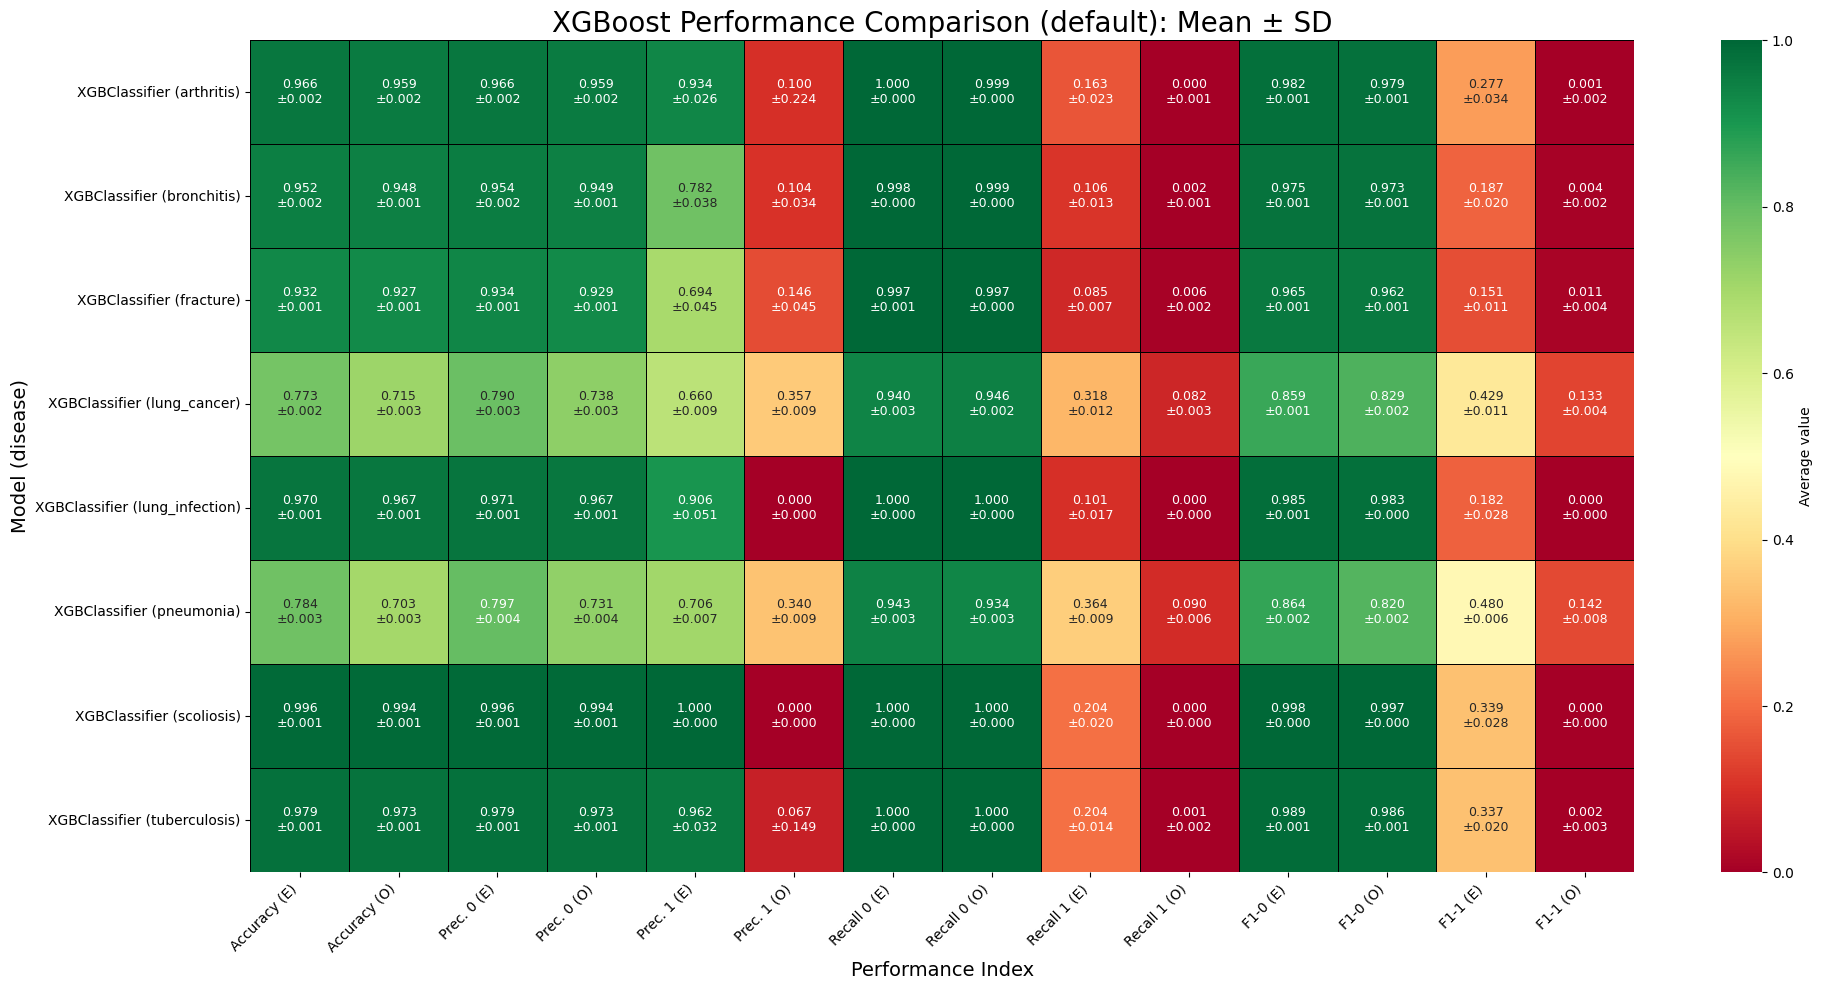

In [ ]:
#default
import io

res_default_T = res_default.T
csv_string = res_default_T.to_csv(index=True)
df_data = pd.read_csv(io.StringIO(csv_string))

metrics_to_plot = [
    'acc_e', 'acc_o',
    'p0_e', 'p0_o',
    'p1_e', 'p1_o',
    'r0_e', 'r0_o',
    'r1_e', 'r1_o',
    'f1_0_e', 'f1_0_o',
    'f1_1_e', 'f1_1_o',
]

new_col_names = {
    'acc_e': 'Accuracy (E)', 'acc_o': 'Accuracy (O)',
    'p0_e': 'Prec. 0 (E)', 'p0_o': 'Prec. 0 (O)',
    'p1_e': 'Prec. 1 (E)', 'p1_o': 'Prec. 1 (O)',
    'r0_e': 'Recall 0 (E)', 'r0_o': 'Recall 0 (O)',
    'r1_e': 'Recall 1 (E)', 'r1_o': 'Recall 1 (O)',
    'f1_0_e': 'F1-0 (E)', 'f1_0_o': 'F1-0 (O)',
    'f1_1_e': 'F1-1 (E)', 'f1_1_o': 'F1-1 (O)',
}

grouped = df_data.groupby(['Model', 'Disease'])[metrics_to_plot]
mean_df = grouped.mean()
std_df = grouped.std()

new_index = [f"{m} ({d})" for m, d in mean_df.index]
mean_df.index = new_index
std_df.index = new_index

mean_df = mean_df.rename(columns=new_col_names)
std_df = std_df.rename(columns=new_col_names)

annot_df = mean_df.copy().astype(str)
for col in mean_df.columns:
    annot_df[col] = mean_df[col].map('{:.3f}'.format) + "\n±" + std_df[col].map('{:.3f}'.format)

plt.figure(figsize=(20, 10))

sns.heatmap(
    mean_df,
    annot=annot_df,
    fmt="",
    cmap='RdYlGn',
    linewidths=.5,
    linecolor='black',
    annot_kws={"size": 9},
    cbar_kws={'label': 'Average value'}
)

plt.title('XGBoost Performance Comparison (default): Mean ± SD', fontsize=20)
plt.ylabel('Model (disease)', fontsize=14)
plt.xlabel('Performance Index', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

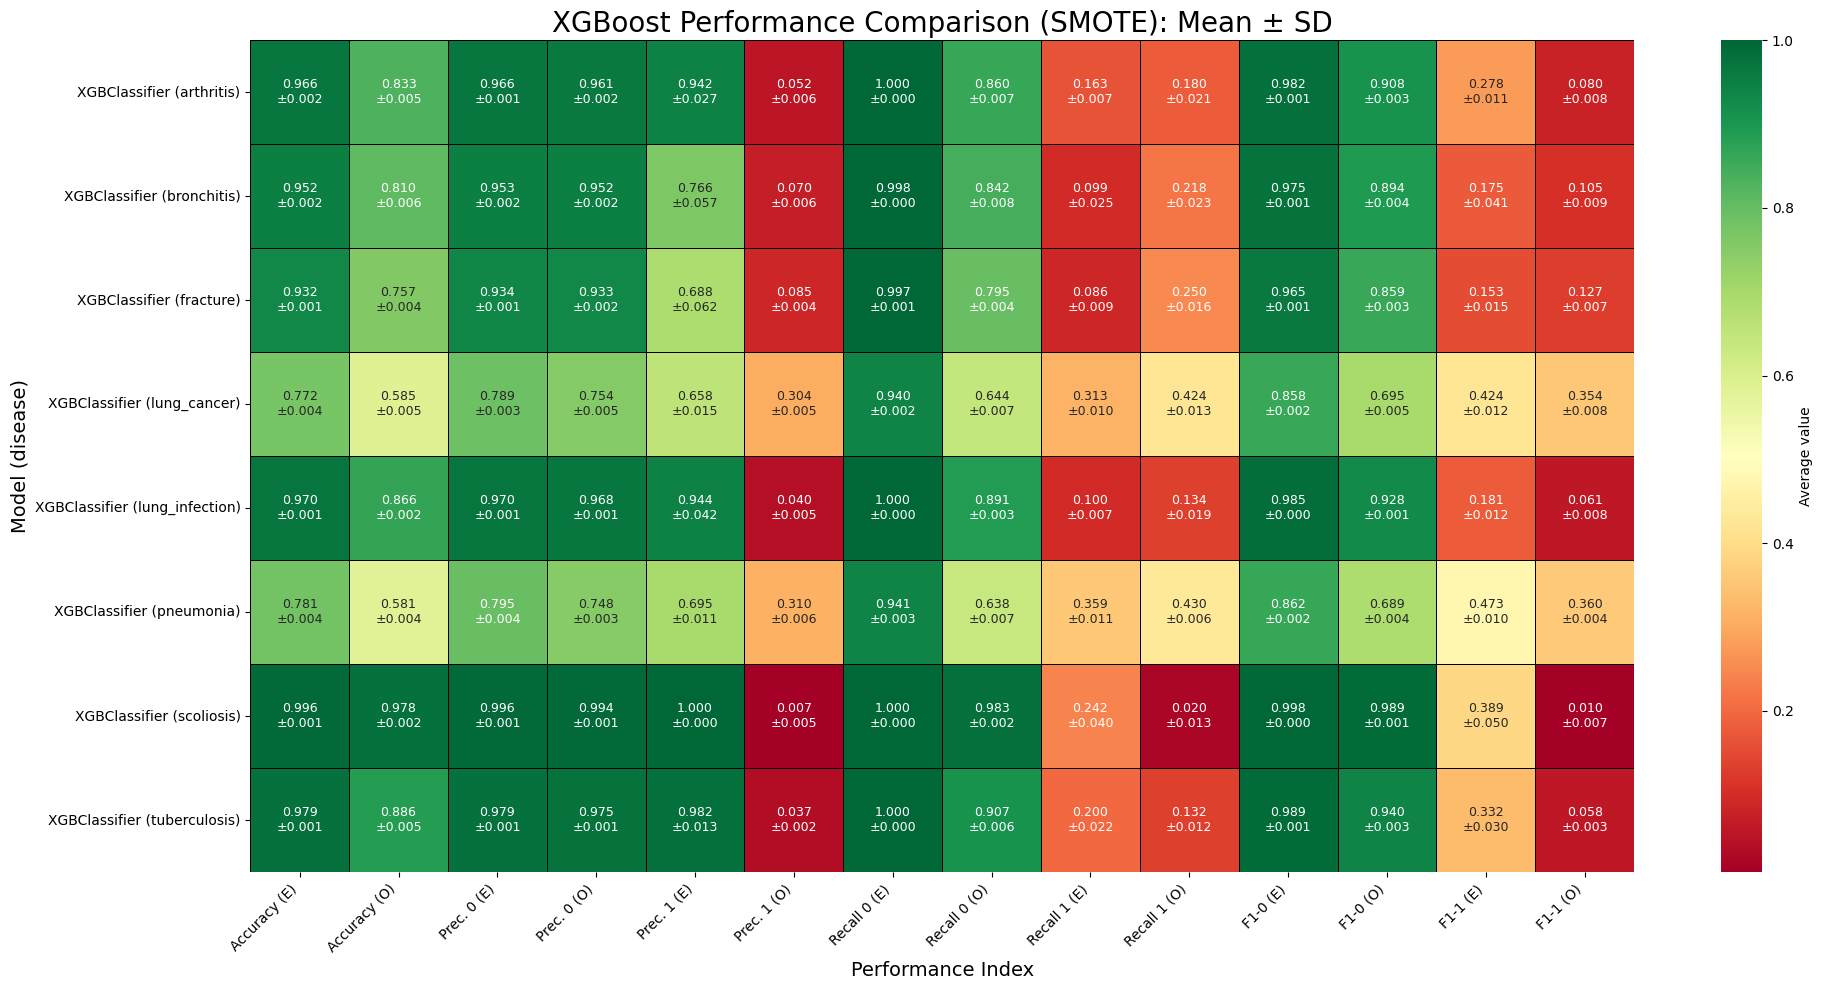

In [ ]:
#SMOTE
import io

res_smote_T = res_smote.T
csv_string = res_smote_T.to_csv(index=True)
df_data = pd.read_csv(io.StringIO(csv_string))

metrics_to_plot = [
    'acc_e', 'acc_o',
    'p0_e', 'p0_o',
    'p1_e', 'p1_o',
    'r0_e', 'r0_o',
    'r1_e', 'r1_o',
    'f1_0_e', 'f1_0_o',
    'f1_1_e', 'f1_1_o',
]

new_col_names = {
    'acc_e': 'Accuracy (E)', 'acc_o': 'Accuracy (O)',
    'p0_e': 'Prec. 0 (E)', 'p0_o': 'Prec. 0 (O)',
    'p1_e': 'Prec. 1 (E)', 'p1_o': 'Prec. 1 (O)',
    'r0_e': 'Recall 0 (E)', 'r0_o': 'Recall 0 (O)',
    'r1_e': 'Recall 1 (E)', 'r1_o': 'Recall 1 (O)',
    'f1_0_e': 'F1-0 (E)', 'f1_0_o': 'F1-0 (O)',
    'f1_1_e': 'F1-1 (E)', 'f1_1_o': 'F1-1 (O)',
}

grouped = df_data.groupby(['Model', 'Disease'])[metrics_to_plot]
mean_df = grouped.mean()
std_df = grouped.std()

new_index = [f"{m} ({d})" for m, d in mean_df.index]
mean_df.index = new_index
std_df.index = new_index

mean_df = mean_df.rename(columns=new_col_names)
std_df = std_df.rename(columns=new_col_names)

annot_df = mean_df.copy().astype(str)
for col in mean_df.columns:
    annot_df[col] = mean_df[col].map('{:.3f}'.format) + "\n±" + std_df[col].map('{:.3f}'.format)

plt.figure(figsize=(20, 10))

sns.heatmap(
    mean_df,
    annot=annot_df,
    fmt="",
    cmap='RdYlGn',
    linewidths=.5,
    linecolor='black',
    annot_kws={"size": 9},
    cbar_kws={'label': 'Average value'}
)

plt.title('XGBoost Performance Comparison (SMOTE): Mean ± SD', fontsize=20)
plt.ylabel('Model (disease)', fontsize=14)
plt.xlabel('Performance Index', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

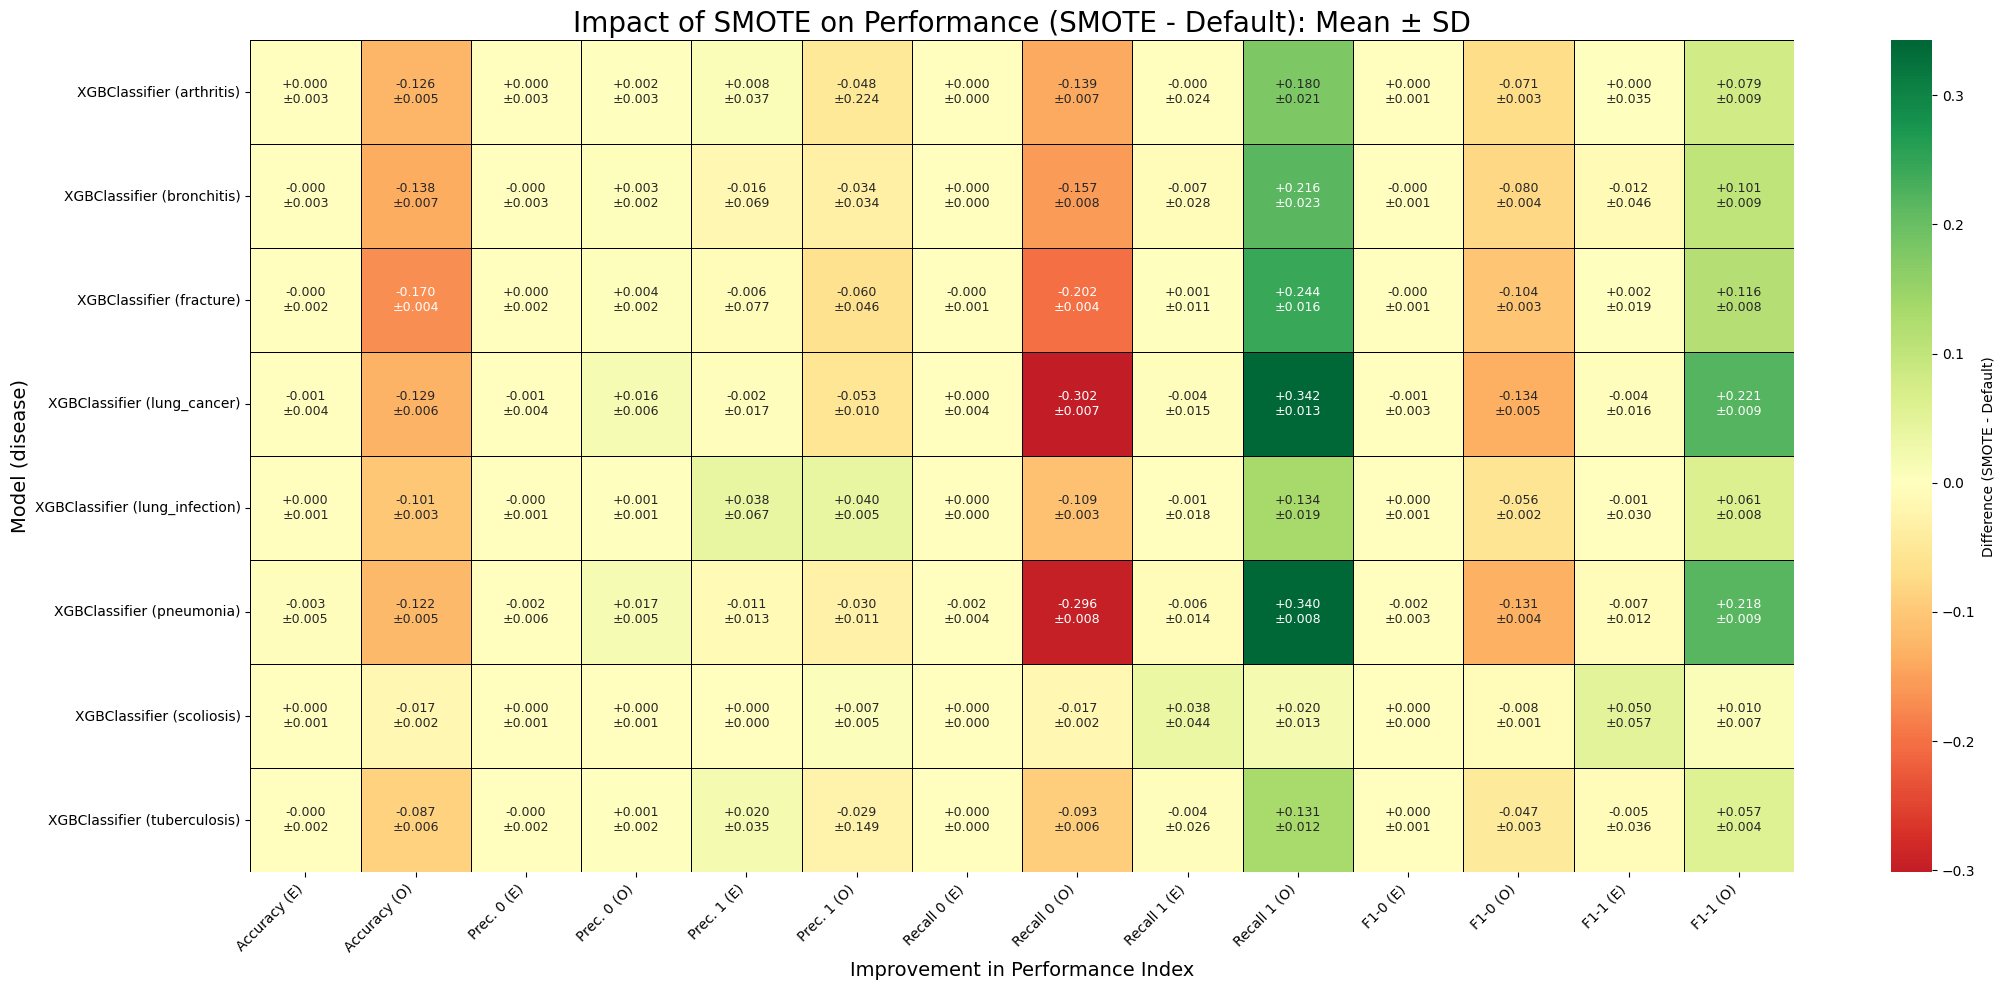

In [ ]:
def get_stats(res_df):
    res_T = res_df.T
    csv_string = res_T.to_csv(index=True)
    df_data = pd.read_csv(io.StringIO(csv_string))

    grouped = df_data.groupby(['Model', 'Disease'])[metrics_to_plot]
    return grouped.mean(), grouped.std()

mean_def, std_def = get_stats(res_default)
mean_smo, std_smo = get_stats(res_smote)

diff_mean = mean_smo - mean_def

diff_std = np.sqrt(std_smo**2 + std_def**2)

new_index = [f"{m} ({d})" for m, d in diff_mean.index]
diff_mean.index = new_index
diff_std.index = new_index

diff_mean = diff_mean.rename(columns=new_col_names)
diff_std = diff_std.rename(columns=new_col_names)

annot_diff = diff_mean.copy().astype(str)
for col in diff_mean.columns:
    annot_diff[col] = diff_mean[col].map('{:+.3f}'.format) + "\n±" + diff_std[col].map('{:.3f}'.format)

plt.figure(figsize=(22, 10))

sns.heatmap(
    diff_mean,
    annot=annot_diff,
    fmt="",
    cmap='RdYlGn',
    center=0,
    linewidths=.5,
    linecolor='black',
    annot_kws={"size": 9},
    cbar_kws={'label': 'Difference (SMOTE - Default)'}
)

plt.title('Impact of SMOTE on Performance (SMOTE - Default): Mean ± SD', fontsize=20)
plt.ylabel('Model (disease)', fontsize=14)
plt.xlabel('Improvement in Performance Index', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()